In [68]:
import pandas as pd
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import numpy as np
import geopandas as gpd
import os
import contextily as ctx
from shapely.geometry import Point

In [5]:
# Paths
deployments_csv = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\ssusa_finaldeployments.csv"
clustered_excel = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\Clustered_Data_Updated.xlsx"

# Load data
df_deployments = pd.read_csv(deployments_csv)
df_clustered = pd.read_excel(clustered_excel)

# Extract Deployment_IDs from Excel (assuming column name is 'Deployment_ID')
deployment_ids_in_excel = df_clustered['Deployment_ID'].unique()

# Filter deployments to only those Deployment_IDs present in Excel
filtered_deployments = df_deployments[df_deployments['Deployment_ID'].isin(deployment_ids_in_excel)]

# Count distinct years per Deployment_ID
distinct_years_count = filtered_deployments.groupby('Deployment_ID')['Year'].nunique()

# Count how many Deployment_IDs have each distinct year count
count_distribution = distinct_years_count.value_counts().sort_index()

print(count_distribution)

Year
1    9508
2      46
Name: count, dtype: int64


In [6]:
# Select only Deployment_ID and Cluster_Agglo_Updated columns from clustered data
df_clustered_subset = df_clustered[['Deployment_ID', 'Cluster_Agglo_Updated']]

# Merge on Deployment_ID (inner join to keep only matching Deployment_IDs)
df_merged = df_deployments.merge(df_clustered_subset, on='Deployment_ID', how='inner')

# Count distinct years per cluster
distinct_years_per_cluster = df_merged.groupby('Cluster_Agglo_Updated')['Year'].nunique()

# Count distribution of how many clusters have a given number of distinct years
count_distribution = distinct_years_per_cluster.value_counts().sort_index()

print(count_distribution)

Year
1    86
2    30
3    17
4    22
5    43
Name: count, dtype: int64


In [11]:
# Step 1: Count records and unique years per Deployment_ID
deployment_stats = (
    df_merged.groupby('Cluster_Agglo_Updated')
    .agg(record_count=('Year', 'count'), unique_years_count=('Year', 'nunique'))
    .reset_index()
)

# Step 2: Group by unique_years_count and sum the record_count
summary = (
    deployment_stats
    .groupby('unique_years_count')['record_count']
    .sum()
    .sort_index()
)

print(summary)

unique_years_count
1    1295
2     954
3    1074
4    1459
5    4818
Name: record_count, dtype: int64


In [23]:
# ---------------------------------------------
# Step 3: Filter clusters where unique_year_count == 5
# ---------------------------------------------
clusters_with_5_years = deployment_stats[deployment_stats['unique_years_count'] >= 5]['Cluster_Agglo_Updated']

# Filter the deployment-level merged data for those clusters
filtered_deployments = df_merged[df_merged['Cluster_Agglo_Updated'].isin(clusters_with_5_years)]

# Get the Deployment_IDs from these filtered deployments
deployment_ids_with_5_years = filtered_deployments['Deployment_ID'].unique()

# ---------------------------------------------
# Step 4: Load snapshot data and filter
# ---------------------------------------------
# Read the merged snapshot dataset
df_snapshot = pd.read_csv( r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\merged_snapshot_usa_with_label.csv")

# Filter it to only include Deployment_IDs with 5-year clusters
filtered_snapshot = df_snapshot[df_snapshot['Deployment_ID'].isin(deployment_ids_with_5_years)]
deployment_ids_with_5_years2 = df_snapshot['Deployment_ID'].unique()

# ---------------------------------------------
# Step 5: Report number of matched records
# ---------------------------------------------
print(f"\nNumber of deployments with 5 unique years - before filtering : {len(deployment_ids_with_5_years2)}")
print(f"Number of records in merged snapshot for these deployments  - before filtering : {len(df_snapshot)}")
print(f"\nNumber of deployments with 5 unique years: {len(deployment_ids_with_5_years)}")
print(f"Number of records in merged snapshot for these deployments: {len(filtered_snapshot)}")

C:\Users\sagni\AppData\Local\Temp\ipykernel_28132\3411936815.py:16: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_snapshot = pd.read_csv( r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\merged_snapshot_usa_with_label.csv")



Number of deployments with 5 unique years - before filtering : 9554
Number of records in merged snapshot for these deployments  - before filtering : 885087

Number of deployments with 5 unique years: 4799
Number of records in merged snapshot for these deployments: 478810


In [24]:
# Select only Deployment_ID and Cluster_Agglo_Updated columns from clustered data
df_clustered_subset = df_clustered[['Deployment_ID', 'Cluster_Agglo_Updated']]
df_clustered_subset = df_clustered_subset[df_clustered_subset['Cluster_Agglo_Updated'].isin(clusters_with_5_years)]

# Merge on Deployment_ID (inner join to keep only matching Deployment_IDs)
final = df_snapshot.merge(df_clustered_subset, on='Deployment_ID', how='inner')
print(f"Number of records in final: {len(final)}")

Number of records in final: 478810


In [25]:
final.head()

,Year,Project,Camera_Trap_Array,Deployment_ID,Sequence_ID,Start_Time,End_Time,Class,Order,Family,...,Survey_Nights,Latitude,Longitude,Habitat,Development_Level,Feature_Type,x,y,cluster_label,Cluster_Agglo_Updated
0,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s1,2019/08/31 06:50:00,2019/08/31 06:50:00,mammalia,carnivora,ursidae,...,64,59.42643,-136.2225,forest,wild,water source,-1.097526e+06,1.305164e+07,16,156
1,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s2,2019/08/31 14:15:00,2019/08/31 14:17:00,mammalia,carnivora,ursidae,...,64,59.42643,-136.2225,forest,wild,water source,-1.097526e+06,1.305164e+07,16,156
2,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s3,2019/08/31 18:22:00,2019/08/31 18:22:00,mammalia,carnivora,ursidae,...,64,59.42643,-136.2225,forest,wild,water source,-1.097526e+06,1.305164e+07,16,156
3,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s4,2019/08/31 20:58:00,2019/08/31 20:58:00,mammalia,carnivora,ursidae,...,64,59.42643,-136.2225,forest,wild,water source,-1.097526e+06,1.305164e+07,16,156
4,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s4,2019/08/31 20:58:00,2019/08/31 20:58:00,mammalia,carnivora,ursidae,...,64,59.42643,-136.2225,forest,wild,water source,-1.097526e+06,1.305164e+07,16,156


In [29]:
# Step 1: Filter and dedupe
df = final[['Year', 'Species', 'Cluster_Agglo_Updated']].drop_duplicates()

# Ensure Year is sorted as int
df['Year'] = df['Year'].astype(int)
years = sorted(df['Year'].unique())  # [2019, 2020, 2021, 2022, 2023]

# ------------------ Species Movement: Jaccard of Clusters ------------------

species_year_clusters = defaultdict(lambda: defaultdict(set))

# Build mapping: Species → Year → Set of Clusters
for _, row in df.iterrows():
    species_year_clusters[row['Species']][row['Year']].add(row['Cluster_Agglo_Updated'])

species_jaccard_scores = []

for species, year_map in species_year_clusters.items():
    for y1, y2 in zip(years, years[1:]):  # consecutive year pairs
        set1 = year_map.get(y1, set())
        set2 = year_map.get(y2, set())
        if set1 or set2:
            intersection = len(set1 & set2)
            union = len(set1 | set2)
            jaccard = intersection / union if union != 0 else None
            species_jaccard_scores.append({
                'Species': species,
                'Year1': y1,
                'Year2': y2,
                'JaccardSimilarity': jaccard
            })

df_species_movement = pd.DataFrame(species_jaccard_scores)

# ------------------ Location Movement: Jaccard of Species ------------------

cluster_year_species = defaultdict(lambda: defaultdict(set))

# Build mapping: Cluster → Year → Set of Species
for _, row in df.iterrows():
    cluster_year_species[row['Cluster_Agglo_Updated']][row['Year']].add(row['Species'])

cluster_jaccard_scores = []

for cluster, year_map in cluster_year_species.items():
    for y1, y2 in zip(years, years[1:]):  # consecutive year pairs
        set1 = year_map.get(y1, set())
        set2 = year_map.get(y2, set())
        if set1 or set2:
            intersection = len(set1 & set2)
            union = len(set1 | set2)
            jaccard = intersection / union if union != 0 else None
            cluster_jaccard_scores.append({
                'Cluster_Agglo_Updated': cluster,
                'Year1': y1,
                'Year2': y2,
                'JaccardSimilarity': jaccard
            })

df_cluster_movement = pd.DataFrame(cluster_jaccard_scores)

In [101]:
# Most moving species = lowest average Jaccard
# Insights You Can Drive
#     Low Jaccard scores for a species over time → Highly moving species
#     High Jaccard scores → Stationary or consistent habitat species

# Count frequency of each species
species_freq = df_snapshot['Species'].value_counts()

# Define threshold — e.g., species with at least 50 sightings
threshold = 3000
frequent_species = species_freq[species_freq >= threshold].index.tolist()

# Filter df_species_movement to only those frequent species
df_species_movement_filtered = df_species_movement[
    df_species_movement['Species'].isin(frequent_species)
]

df_species_movement_filtered.groupby('Species')['JaccardSimilarity'].mean().sort_values()

Species
leucopus            0.100694
migratorius         0.364852
canadensis          0.467479
cinereoargenteus    0.605961
vulpes              0.606589
catus               0.652174
taurus              0.678571
familiaris          0.693280
hudsonicus          0.700149
rufus               0.709109
niger               0.709232
americanus          0.767974
hemionus            0.769444
floridanus          0.793868
striatus            0.811526
gallopavo           0.840996
scrofa              0.870536
lotor               0.900501
carolinensis        0.914235
virginiana          0.931897
sapiens             0.947674
novemcinctus        0.954545
latrans             0.969512
virginianus         0.993421
arctos              1.000000
Name: JaccardSimilarity, dtype: float64

In [31]:
# Most stable locations = highest average Jaccard
# Same logic applies for locations:
#     Low scores = site has high species turnover
#     High scores = stable ecosystem
df_cluster_movement.groupby('Cluster_Agglo_Updated')['JaccardSimilarity'].mean().sort_values(ascending=False)

Cluster_Agglo_Updated
189    0.740712
169    0.725519
24     0.702610
176    0.700739
96     0.695887
196    0.692814
111    0.674466
131    0.669160
5      0.663140
170    0.660610
8      0.655534
19     0.654762
116    0.651382
157    0.650752
1      0.648046
37     0.639877
156    0.624632
75     0.618475
130    0.615630
42     0.610417
88     0.609525
151    0.608981
64     0.602892
147    0.602493
0      0.602273
21     0.586023
164    0.578303
56     0.576747
141    0.568865
54     0.566907
183    0.554774
125    0.552778
99     0.545122
10     0.542888
71     0.538356
79     0.525123
61     0.517757
4      0.506886
29     0.490575
91     0.484936
53     0.449924
51     0.444748
74     0.393304
Name: JaccardSimilarity, dtype: float64

## Most stable locations

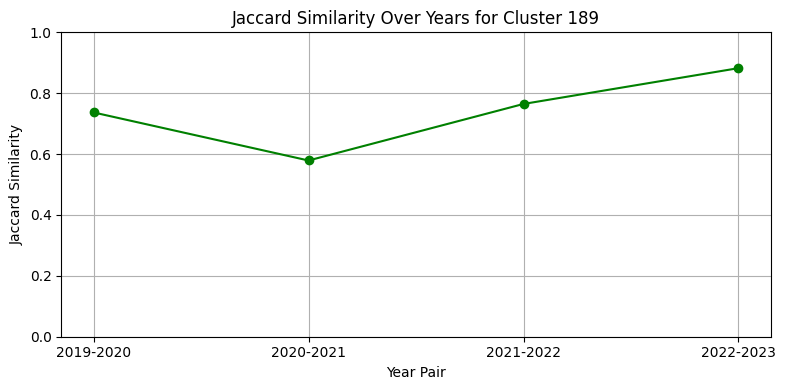

In [39]:
df_cluster_189 = df_cluster_movement[df_cluster_movement['Cluster_Agglo_Updated'] == 189]

plt.figure(figsize=(8, 4))
plt.plot(
    df_cluster_189['Year1'].astype(str) + "-" + df_cluster_189['Year2'].astype(str),
    df_cluster_189['JaccardSimilarity'],
    marker='o',
    color='green'
)
plt.title("Jaccard Similarity Over Years for Cluster 189")
plt.xlabel("Year Pair")
plt.ylabel("Jaccard Similarity")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

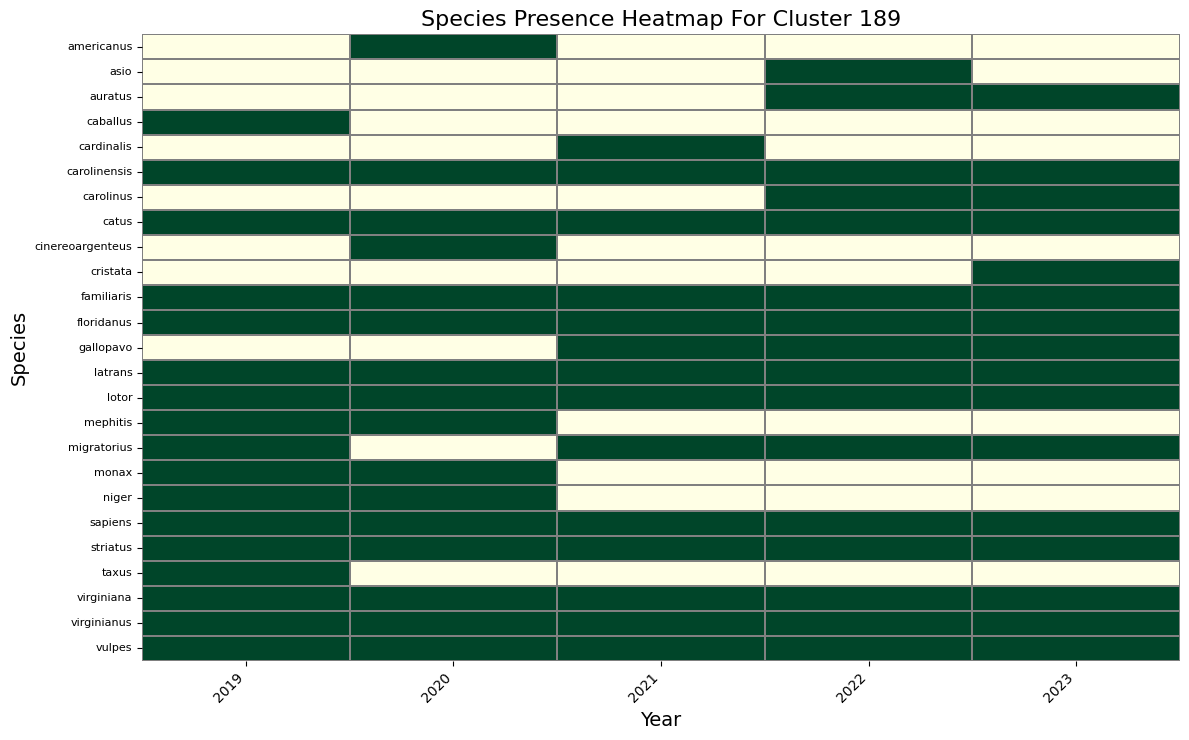

In [50]:
# Filter to Cluster 189
df_189 = df[df['Cluster_Agglo_Updated'] == 189]

# Create binary matrix: rows = Species, columns = Year
pivot_189 = df_189.pivot_table(index='Species', columns='Year', aggfunc='size', fill_value=0)

# Binarize (1 = present, 0 = absent)
pivot_189 = (pivot_189 > 0).astype(int)

plt.figure(figsize=(12, max(6, 0.3 * pivot_189.shape[0])))

sns.heatmap(
    pivot_189,
    cmap='YlGn',
    cbar=False,
    linewidths=0.3,
    linecolor='gray',
    annot=False,  # Change to True if you want 1/0 annotation
    fmt='d',
    square=False
)

plt.title("Species Presence Heatmap For Cluster 189", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Species", fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

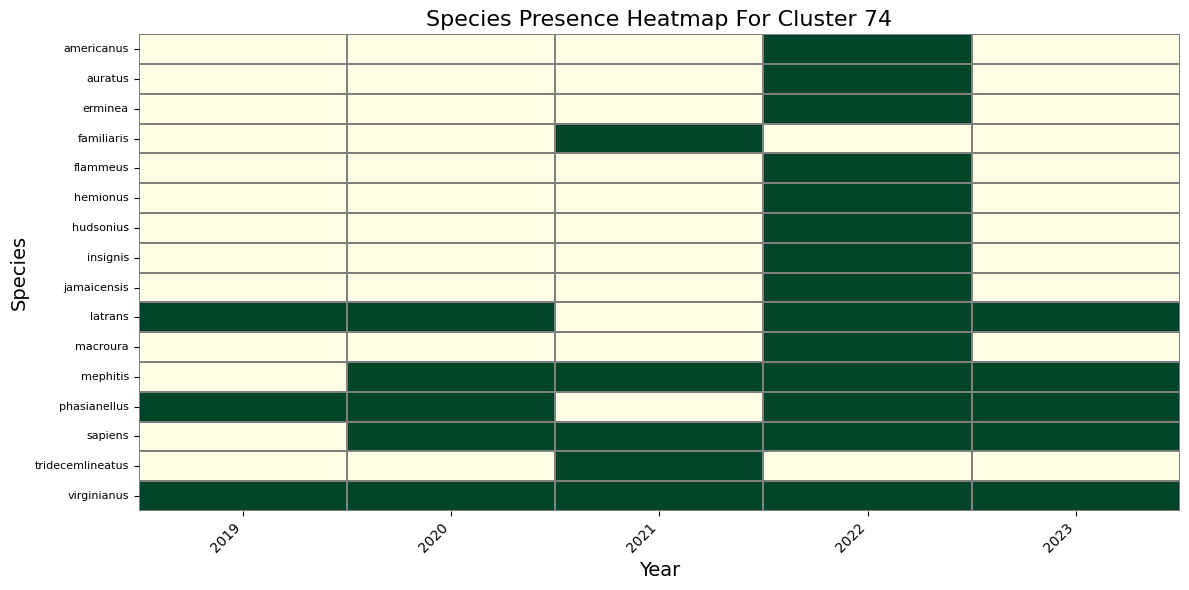

In [51]:
# Filter to Cluster 74
df_189 = df[df['Cluster_Agglo_Updated'] == 74]

# Create binary matrix: rows = Species, columns = Year
pivot_189 = df_189.pivot_table(index='Species', columns='Year', aggfunc='size', fill_value=0)

# Binarize (1 = present, 0 = absent)
pivot_189 = (pivot_189 > 0).astype(int)

plt.figure(figsize=(12, max(6, 0.3 * pivot_189.shape[0])))

sns.heatmap(
    pivot_189,
    cmap='YlGn',
    cbar=False,
    linewidths=0.3,
    linecolor='gray',
    annot=False,  # Change to True if you want 1/0 annotation
    fmt='d',
    square=False
)

plt.title("Species Presence Heatmap For Cluster 74", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Species", fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

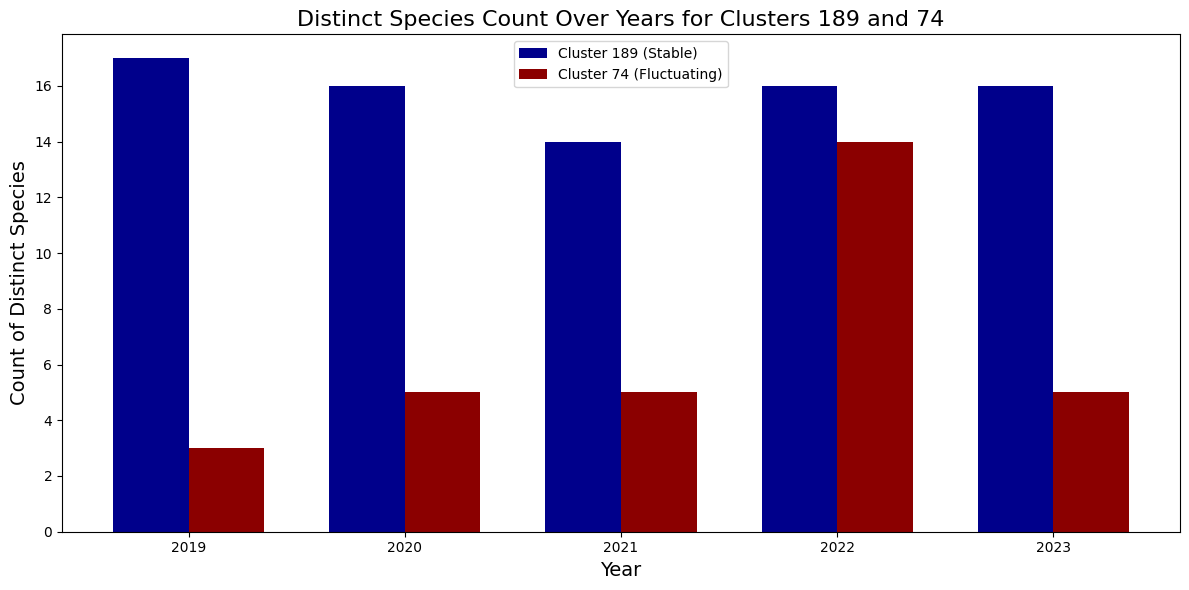

In [66]:
# Function remains the same
def species_count_per_year(df, cluster_id):
    cluster_df = df[df['Cluster_Agglo_Updated'] == cluster_id]
    species_per_year = (
        cluster_df.groupby('Year')['Species']
        .nunique()
        .sort_index()
    )
    return species_per_year

# Get species counts per year
species_189 = species_count_per_year(df, 189)
species_74 = species_count_per_year(df, 74)

# Combine years from both to ensure alignment
all_years = sorted(set(species_189.index).union(set(species_74.index)))
species_189 = species_189.reindex(all_years, fill_value=0)
species_74 = species_74.reindex(all_years, fill_value=0)

# Bar width and positions
x = np.arange(len(all_years))
bar_width = 0.35

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, species_189.values, width=bar_width, label='Cluster 189 (Stable)', color='darkblue')
plt.bar(x + bar_width/2, species_74.values, width=bar_width, label='Cluster 74 (Fluctuating)', color='darkred')

# Formatting
plt.title('Distinct Species Count Over Years for Clusters 189 and 74', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count of Distinct Species', fontsize=14)
plt.xticks(x, all_years, rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
# Select only Deployment_ID and Cluster_Agglo_Updated columns from clustered data
df_clustered_subset = df_clustered[['Deployment_ID', 'Cluster_Agglo_Updated']]

# Merge on Deployment_ID (inner join to keep only matching Deployment_IDs)
df_merged = df_deployments.merge(df_clustered_subset, on='Deployment_ID', how='inner')
df_merged.columns

Index(['Year', 'Project', 'Camera_Trap_Array', 'Site_Name', 'Deployment_ID',
       'Start_Date', 'End_Date', 'Survey_Nights', 'Latitude', 'Longitude',
       'Habitat', 'Development_Level', 'Feature_Type',
       'Cluster_Agglo_Updated'],
      dtype='object')

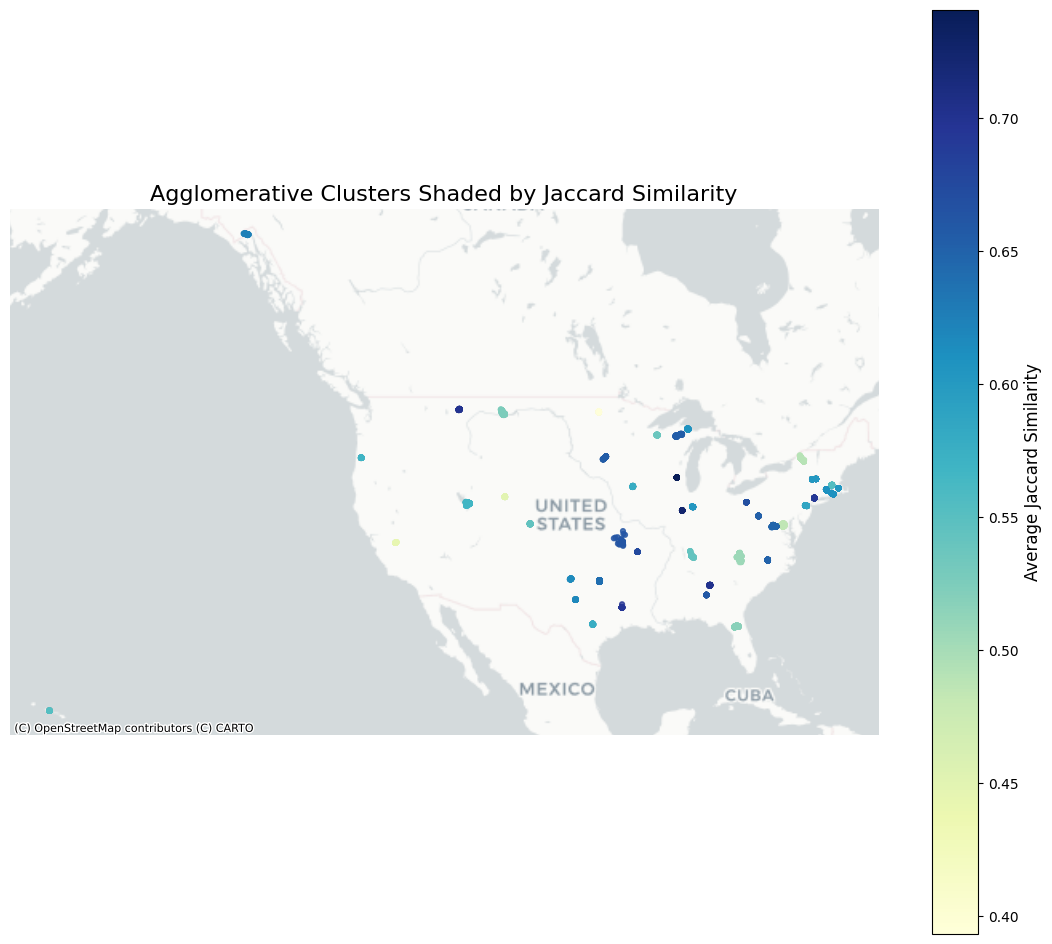

In [70]:
# Step 1: Compute average Jaccard similarity per cluster
cluster_jaccard_avg = (
    df_cluster_movement
    .groupby('Cluster_Agglo_Updated')['JaccardSimilarity']
    .mean()
    .reset_index()
)

# Step 2: Merge deployment + cluster info
df_clustered_subset = df_clustered[['Deployment_ID', 'Cluster_Agglo_Updated']]
df_merged = df_deployments.merge(df_clustered_subset, on='Deployment_ID', how='inner')

# Step 3: Merge in Jaccard scores
df_merged = df_merged.merge(cluster_jaccard_avg, on='Cluster_Agglo_Updated', how='left')

# Step 4: Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df_merged['Longitude'], df_merged['Latitude'])]
gdf = gpd.GeoDataFrame(df_merged, geometry=geometry, crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)

# Step 5: Plot using JaccardSimilarity for color shading
fig, ax = plt.subplots(figsize=(14, 12))

plot = gdf.plot(
    column='JaccardSimilarity',
    cmap='YlGnBu',         # Good colormap for similarity scores
    legend=True,
    markersize=12,
    alpha=0.8,
    ax=ax
)

# Adjust legend
cbar = plot.get_figure().get_axes()[1]
cbar.set_ylabel('Average Jaccard Similarity', fontsize=12)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Set title and remove axes
ax.set_title('Agglomerative Clusters Shaded by Jaccard Similarity', fontsize=16)
ax.set_axis_off()

# Step 6: Save figure
output_dir = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots"
os.makedirs(output_dir, exist_ok=True)
fig_path = os.path.join(output_dir, "Cluster_Agglo_Shaded_JaccardSimilarity.png")
plt.savefig(fig_path, dpi=600, bbox_inches='tight')
plt.show()

## Most moving species

In [73]:
# Most moving species = lowest average Jaccard
# Insights You Can Drive
#     Low Jaccard scores for a species over time → Highly moving species
#     High Jaccard scores → Stationary or consistent habitat species

In [91]:
import pandas as pd

# Step 1: Load subset with clustering info
df_clustered_subset = df_clustered[['Deployment_ID', 'Cluster_Agglo_Updated']]

# Step 2: Read the snapshot data
df_snapshot = pd.read_csv(
    r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\merged_snapshot_usa_with_label.csv",
    low_memory=False
)

# Step 3: Merge on Deployment_ID
df_merged = df_snapshot.merge(df_clustered_subset, on='Deployment_ID', how='inner')

print(f"Total merged records: {len(df_merged)}")

# Optional: Check columns available
print(df_merged.columns)

# Step 4: Filter for species 'leucopus'
df_leucopus = df_merged[df_merged['Species'].str.lower() == 'leucopus']

print(f"Filtered records for 'leucopus': {len(df_leucopus)}")


Total merged records: 885087
Index(['Year', 'Project', 'Camera_Trap_Array', 'Deployment_ID', 'Sequence_ID',
       'Start_Time', 'End_Time', 'Class', 'Order', 'Family', 'Genus',
       'Species', 'Common_Name', 'Age', 'Sex', 'Group_Size', 'Site_Name',
       'Start_Date', 'End_Date', 'Survey_Nights', 'Latitude', 'Longitude',
       'Habitat', 'Development_Level', 'Feature_Type', 'x', 'y',
       'cluster_label', 'Cluster_Agglo_Updated'],
      dtype='object')
Filtered records for 'leucopus': 5349


In [95]:
# Step 1: Prepare data (assumes df_merged already created and filtered)
df_vulpes = df_merged[df_merged['Species'].str.lower() == 'vulpes']
df_vulpes = df_vulpes[['Year', 'Latitude', 'Longitude']].dropna()

# Step 2: Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df_vulpes['Longitude'], df_vulpes['Latitude'])]
gdf = gpd.GeoDataFrame(df_vulpes, geometry=geometry, crs="EPSG:4326").to_crs(epsg=3857)

# Step 3: Create output directory
output_dir = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\vulpes_gif"
os.makedirs(output_dir, exist_ok=True)

# Step 4: Plot one frame per year
frame_paths = []
all_bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]

for year in sorted(gdf['Year'].unique()):
    yearly_gdf = gdf[gdf['Year'] == year]

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set consistent bounds
    ax.set_xlim(all_bounds[[0, 2]])
    ax.set_ylim(all_bounds[[1, 3]])

    # Plot as black dots
    yearly_gdf.plot(ax=ax, color='black', markersize=10)

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Style
    ax.set_title(f"'vulpes' Locations in {year}", fontsize=16)
    ax.set_axis_off()

    # Save each frame
    frame_path = os.path.join(output_dir, f"vulpes_{year}.png")
    plt.savefig(frame_path, dpi=300, bbox_inches='tight')
    plt.close()
    frame_paths.append(frame_path)

# Step 5: Generate GIF
gif_path = os.path.join(output_dir, "vulpes_movement.gif")
images = [imageio.v2.imread(p) for p in frame_paths]
imageio.mimsave(gif_path, images, fps=1)

print(f"GIF saved at: {gif_path}")

GIF saved at: C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\vulpes_gif\vulpes_movement.gif


In [103]:
# Step 1: Prepare data (assumes df_merged already created and filtered)
df_latrans = df_merged[df_merged['Species'].str.lower() == 'latrans']
df_latrans = df_latrans[['Year', 'Latitude', 'Longitude']].dropna()

# Step 2: Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df_latrans['Longitude'], df_latrans['Latitude'])]
gdf = gpd.GeoDataFrame(df_latrans, geometry=geometry, crs="EPSG:4326").to_crs(epsg=3857)

# Step 3: Create output directory
output_dir = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\latrans_gif"
os.makedirs(output_dir, exist_ok=True)

# Step 4: Plot one frame per year
frame_paths = []
all_bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]

for year in sorted(gdf['Year'].unique()):
    yearly_gdf = gdf[gdf['Year'] == year]

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set consistent bounds
    ax.set_xlim(all_bounds[[0, 2]])
    ax.set_ylim(all_bounds[[1, 3]])

    # Plot as black dots
    yearly_gdf.plot(ax=ax, color='black', markersize=10)

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Style
    ax.set_title(f"'latrans' Locations in {year}", fontsize=16)
    ax.set_axis_off()

    # Save each frame
    frame_path = os.path.join(output_dir, f"latrans_{year}.png")
    plt.savefig(frame_path, dpi=300, bbox_inches='tight')
    plt.close()
    frame_paths.append(frame_path)

# Step 5: Generate GIF
gif_path = os.path.join(output_dir, "latrans_movement.gif")
images = [imageio.v2.imread(p) for p in frame_paths]
imageio.mimsave(gif_path, images, fps=1)

print(f"GIF saved at: {gif_path}")

GIF saved at: C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\latrans_gif\latrans_movement.gif
